# <span style='font-family:"Times New Roman"'> <span styel=''>**WHOLE GENOME DOUBLING ANALYSIS**

*Emile Cohen*
    
 *May 2020*

**Goal:** In this notebook, we analyse all MSK-Imoact Cohort to know the proportion of WGD Samples, the tp53 mutated samples. Then we output a diagram with important information.

---

In [51]:
%run -i '../../../utils/setup_environment.ipy'

import warnings
warnings.filterwarnings('ignore')
from scipy.stats import fisher_exact, ranksums, chi2, norm
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.gridspec as gridspec

data_path = '../../../data/'

Setup environment... done!


<span style="color:green">✅ Working on **mskimpact_env** conda environment.</span>

# MSK-Impact Cohort

## Size

In [207]:
# Loading the data
maf_cohort = pd.read_csv(data_path + 'impact-facets-tp53/new_data_facets/msk_impact_facets_annotated.ccf.maf', sep='\t')
annotated_cohort = pd.read_csv(data_path + 'impact-facets-tp53/new_data_facets/msk_impact_facets_annotated.cohort.txt', sep='\t')
arm_level = pd.read_csv(data_path + 'impact-facets-tp53/new_data_facets/msk_impact_facets_annotated.arm_level.txt', sep='\t')
gene_level = pd.read_csv(data_path + 'impact-facets-tp53/new_data_facets/msk_impact_facets_annotated.gene_level_grepTP53.txt', sep='\t')

The following cell shows the size of the total cohort through the different input files. We see that the cohort is more than 40 000 samples but only 38 465 have mutational information.

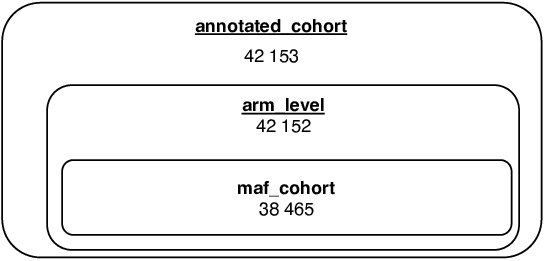

In [52]:
img = WImage(filename='total_cohort.pdf', resolution=150)
img

## WGD column
The annotated_cohort have a column called *wgd*. On the other side, for the TP53 mutated cohort, we computed the WGD states by hand. Let's see if the WGD column is accurate.

In [164]:
#Loading the master_file
master = pd.read_pickle(data_path + 'merged_data/master_file.pkl')
#master = master[['Tumor_Id', 'wgd']]

In [55]:
annotated_cohort_wgd = annotated_cohort[['tumor_sample', 'wgd']]

In [58]:
# left merge 
merged = pd.merge(left=master, right=annotated_cohort_wgd, how='left', left_on='Tumor_Id', right_on='tumor_sample')
merged.head()

Tumor_Id  wgd_x       tumor_sample  wgd_y
0  P-0034223-T01-IM6     -1  P-0034223-T01-IM6  False
1  P-0009819-T01-IM5     -1  P-0009819-T01-IM5  False
2  P-0025956-T01-IM6      1  P-0025956-T01-IM6   True
3  P-0027408-T01-IM6     -1  P-0027408-T01-IM6  False
4  P-0006554-T01-IM5     -1  P-0006554-T01-IM5  False

Now the idea is to compare *wgd_x* and *wgd_y* to see if there are inconsistencies.

In [60]:
# We define a function to create a new column
def check_inconsistencies(x):
    if (x.wgd_x == 1 and x.wgd_y == True) or (x.wgd_x == -1 and x.wgd_y == False):
        return 0
    elif: return 1
    
merged['inconsistencies'] = merged.apply(check_inconsistencies, axis=1)

In [61]:
# now we sum the inconsistencies column to see if we have any inconsistency. We should have 0 for no inconsitencies at all.
merged.inconsistencies.sum()

121

So we have 121 samples with problems: let's take a look.

In [70]:
merged[merged['inconsistencies'] == 1][~merged.wgd_y.isna()]

Tumor_Id  wgd_x       tumor_sample wgd_y  inconsistencies
2596   P-0011205-T03-IM6     -1  P-0011205-T03-IM6  True                1
3906   P-0035720-T01-IM6     -1  P-0035720-T01-IM6  True                1
4201   P-0020803-T02-IM6     -1  P-0020803-T02-IM6  True                1
6153   P-0022193-T02-IM6     -1  P-0022193-T02-IM6  True                1
11524  P-0016952-T02-IM6     -1  P-0016952-T02-IM6  True                1
20395  P-0005192-T01-IM5     -1  P-0005192-T01-IM5  True                1
21326  P-0018318-T01-IM6     -1  P-0018318-T01-IM6  True                1
23992  P-0031102-T06-IM6     -1  P-0031102-T06-IM6  True                1
26782  P-0046593-T02-IM6     -1  P-0046593-T02-IM6  True                1
27950  P-0031010-T03-IM6     -1  P-0031010-T03-IM6  True                1

We see that those inconsistencies come from the fact that some tumor samples have different Normal matched with one of them being with a WGD. They annotate the sample as a WGD sample.

So let's filter annotated_cohort - keep the highest purity matched normal - and see if the inconsistencies are still present.

In [151]:
def normal_samp_duplicates_filter(df, sample_name, purity_name):
    '''
    This function aims to filter out the samples that have the same tumor id but different normal samples.
    We choose to keep only the one with the highest purity in case of duplicates.
    
    Arguments:
        - df: the dataframe we want to clean
        - sample_name: the name of the column containing the sample. Ex: P-0006554-T01-IM5_P-0006554-N01-IM5
        - purity_name: the name of the column containing the purity
    '''
    
    # We first restrain to the interesting columns
    sub_df = df[[sample_name, purity_name]]
    #Create the column with the tumor_id and set it as index to identify the duplicates
    sub_df['Tumor_Id'] = sub_df[sample_name].str[:17]
    sub_df = sub_df.set_index('Tumor_Id')
    # We use the duplicated() method to create a False/True Series if the sample is duplicated
    duplicates_series = sub_df[sample_name].str[:17].duplicated()
    # We then select only samples that are duplicated to obtain the list of duplicated samples
    duplicated_samples = list(duplicates_series[duplicates_series == True].index)

    # We put the sample_name column as Index
    sub_df = sub_df.set_index(sample_name)

    # We can now filter out the samples that are listed in duplicated_samples
    to_be_filtered = []
    for sample in duplicated_samples:
        to_be_filtered.append(sub_df[sub_df.index.str[:17] == sample][['purity']].idxmin()['purity'])
    
    #print(to_be_filtered)
    # Now we filter out the lines that are in the list
    df = df[~df[sample_name].isin(to_be_filtered)]
    
    return df

In [152]:
annotated_cohort_filt = normal_samp_duplicates_filter(annotated_cohort, 'sample_id', 'purity')
annotated_cohort_filt = normal_samp_duplicates_filter(annotated_cohort_filt, 'sample_id', 'purity')
# the last duplicated samples are samples with purity = NaN so we simply use deplicated method
annotated_cohort_filt = annotated_cohort_filt.drop_duplicates(subset='tumor_sample')

In [162]:
annotated_cohort_wgd = annotated_cohort_filt[['tumor_sample', 'wgd']]
merged = pd.merge(left=master, right=annotated_cohort_wgd, how='left', left_on='Tumor_Id', right_on='tumor_sample')
merged['inconsistencies'] = merged.apply(check_inconsistencies, axis=1)
merged[merged['inconsistencies'] == 1]#[~merged.wgd_y.isna()]

Tumor_Id  wgd_x       tumor_sample wgd_y  inconsistencies
495    P-0031435-T01-IM6     -1                NaN   NaN                1
1282   P-0010672-T02-IM5     -1                NaN   NaN                1
1855   P-0027242-T01-IM6     -1                NaN   NaN                1
2906   P-0013827-T01-IM5     -1                NaN   NaN                1
2957   P-0010083-T01-IM5     -1                NaN   NaN                1
3263   P-0020798-T01-IM6     -1                NaN   NaN                1
3271   P-0017938-T01-IM6     -1                NaN   NaN                1
3284   P-0031170-T01-IM6     -1                NaN   NaN                1
3898   P-0035720-T01-IM6     -1  P-0035720-T01-IM6  True                1
3980   P-0036528-T01-IM6     -1                NaN   NaN                1
5936   P-0017305-T01-IM5     -1                NaN   NaN                1
6401   P-0017240-T02-IM6     -1                NaN   NaN                1
6473   P-0016745-T01-IM6     -1                NaN   NaN                1
6480   P-0006119-T01-IM5     -1                NaN   NaN                1
6533   P-0025776-T01-IM6     -1                NaN   NaN                1
6540   P-0019560-T01-IM6     -1                NaN   NaN                1
7324   P-0011588-T01-IM5     -1                NaN   NaN                1
9995   P-0000328-T02-IM6     -1                NaN   NaN                1
10549  P-0019219-T01-IM6     -1                NaN   NaN                1
11679  P-0000416-T02-IM3     -1                NaN   NaN                1
12234  P-0027992-T01-IM6     -1                NaN   NaN                1
12546  P-0023638-T02-IM6     -1                NaN   NaN                1
12765  P-0014014-T01-IM6     -1                NaN   NaN                1
13272  P-0028566-T01-IM6     -1                NaN   NaN                1
13757  P-0015914-T01-IM6     -1                NaN   NaN                1
15355  P-0029600-T02-IM6     -1                NaN   NaN                1
15765  P-0022650-T01-IM6     -1                NaN   NaN                1
16231  P-0004094-T03-IM6     -1                NaN   NaN                1
16448  P-0026525-T02-IM6     -1                NaN   NaN                1
17460  P-0000244-T01-IM3     -1                NaN   NaN                1
17839  P-0014773-T01-IM6     -1                NaN   NaN                1
17950  P-0024980-T01-IM6     -1                NaN   NaN                1
17969  P-0000657-T01-IM3     -1                NaN   NaN                1
19907  P-0000801-T02-IM3     -1                NaN   NaN                1
19961  P-0001378-T01-IM3     -1                NaN   NaN                1
19965  P-0001401-T01-IM3     -1                NaN   NaN                1
20016  P-0001785-T01-IM3     -1                NaN   NaN                1
20108  P-0002550-T01-IM3     -1                NaN   NaN                1
20112  P-0002576-T01-IM3     -1                NaN   NaN                1
20132  P-0002742-T01-IM3     -1                NaN   NaN                1
20137  P-0002748-T01-IM3     -1                NaN   NaN                1
20138  P-0002750-T01-IM3     -1                NaN   NaN                1
20144  P-0002760-T01-IM3     -1                NaN   NaN                1
20169  P-0002936-T02-IM3     -1                NaN   NaN                1
20170  P-0002938-T02-IM3     -1                NaN   NaN                1
20171  P-0002940-T02-IM3     -1                NaN   NaN                1
20172  P-0002942-T02-IM3     -1                NaN   NaN                1
20173  P-0002944-T02-IM3     -1                NaN   NaN                1
20174  P-0002945-T02-IM3     -1                NaN   NaN                1
20175  P-0002946-T02-IM3     -1                NaN   NaN                1
20176  P-0002947-T02-IM3     -1                NaN   NaN                1
20178  P-0002953-T02-IM3     -1                NaN   NaN                1
20234  P-0003697-T01-IM5     -1                NaN   NaN                1
20238  P-0003702-T01

**Conclusion:** We will keep the *wgd* column as the reference for wgd.

# Analysis

## Filtering the annotated_data
1. We do not want duplicates in Tumor_Id
2. As maf_cohort is necessary to know if we have tp53 mutants or not, we will reduce our analysis to the samples of maf_cohort (loss of ~3 600 samples over 42 153)
3. Moreover, we need to access tp53 cn state, so we have to be sure all samples are in gene_level file

In [214]:
annotated_cohort = pd.read_csv(data_path + 'impact-facets-tp53/new_data_facets/msk_impact_facets_annotated.cohort.txt', sep='\t')
maf_cohort = pd.read_csv(data_path + 'impact-facets-tp53/new_data_facets/msk_impact_facets_annotated.ccf.maf', sep='\t')

maf_samples = list(set(maf_cohort.Tumor_Sample_Barcode))

annotated_cohort_filt = normal_samp_duplicates_filter(annotated_cohort, 'sample_id', 'purity')
annotated_cohort_filt = normal_samp_duplicates_filter(annotated_cohort_filt, 'sample_id', 'purity')
# the last duplicated samples are samples with purity = NaN so we simply use deplicated method
cohort = annotated_cohort_filt.drop_duplicates(subset='tumor_sample')

# We take only samples that are in maf_samples
cohort = cohort[cohort.tumor_sample.isin(maf_samples)]

# Finally we want to be able to accesss the TP53 locus copy number state, so we need to make sure all samples are
# in gene_level

# We remove the following samples
cohort = cohort[~cohort.tumor_sample.isin(['P-0000157-T01-IM3',
 'P-0000158-T01-IM3',
 'P-0000204-T01-IM3',
 'P-0000206-T01-IM3',
 'P-0000273-T01-IM3',
 'P-0000308-T01-IM3',
 'P-0000320-T01-IM3',
 'P-0000396-T01-IM3',
 'P-0007206-T01-IM5',
 'P-0011437-T01-IM5',
 'P-0037557-T01-IM6',
 'P-0043334-T01-IM6',
 'P-0043373-T01-IM6',
 'P-0043377-T01-IM6',
 'P-0045294-T01-IM6',
 'P-0045404-T01-IM6'])]

Now we have unique tumor_sample, we can begin the analysis

## WGD Proportion

In [215]:
print('Number of samples with WGD: ' + str(cohort[cohort['wgd'] == True].shape[0]) + ' - ' + str(round(100* cohort[cohort['wgd'] == True].shape[0]/cohort.shape[0],2))+ ' %')
print('Number of samples without WGD: ' + str(cohort[cohort['wgd'] == False].shape[0])  + ' - ' + str(round(100* cohort[cohort['wgd'] == False].shape[0]/cohort.shape[0],2))+ ' %')

Number of samples with WGD: 13717 - 35.68 %
Number of samples without WGD: 24732 - 64.32 %


# Number of TP53 mutated samples in WGD setting
From previous analysis we expect to see a very high proportion of TP53 mutated samples.

In [217]:
cohort_wgd = cohort[cohort['wgd'] == 1]
samples_wgd = list(set(cohort_wgd.tumor_sample))

In [225]:
cohort_wgd.shape[0]

13717

In [218]:
# We filter the maf_cohort on the wgd samples
maf_cohort_wgd = maf_cohort[maf_cohort.Tumor_Sample_Barcode.isin(samples_wgd)]

In [220]:
# We count the samples that has at least one tp53 mutation
n = len(set(maf_cohort_wgd[maf_cohort['Hugo_Symbol'] == 'TP53'].Tumor_Sample_Barcode))
print('Number of TP53 mutated samples in WGD setting: ' + str(n) + ' - ' + str(round(100*n/len(cohort_wgd),2)) + ' %')

Number of TP53 mutated samples in WGD setting: 8992 - 65.55 %


In [230]:
gene_level[gene_level['gene'] == 'TP53'][gene_level['sample'].str[:17].isin(samples_wgd)][]

Empty DataFrame
Columns: [sample, gene, chrom, gene_start, gene_end, tsg, seg, median_cnlr_seg, segclust, seg_start, seg_end, cf.em, tcn.em, lcn.em, cf, tcn, lcn, seg_length, mcn, genes_on_seg, gene_snps, gene_het_snps, spans_segs, cn_state, filter]
Index: []